# Geographical mapping with `elevatr` and `tif`

An attempt to get geo working for our data.

The successful approach uses `elevatr` to download elevation data, converts the raster to a tif, and then shows this with cities as points.

We can adapt any data source to this approach, in particular we can show our language data on these maps.


In [1]:
# Remember that you can !pip install <packagename> to install any missing packages.

import elevatr as elv # This package makes downloading elevation data easy
import numpy as np # Numpy is a core package for calculations; its only needed for setting our colors.
import pandas as pd # Pandas is a core package for data frames
import geopandas as gpd # geopandas is a core package for geographic data.
from shapely.geometry import Point # Allows ployying points with geopandas and rxr
import rioxarray as rxr # We will convert our elevation data to this format which is easier to plot 
import matplotlib.pyplot as plt # Needed for standard plotting
import matplotlib.colors as mcolors # Needed to manually set colors
from adjustText import adjust_text # Needed to prevent text overlapping
import plotly.express as px # Only needed for the final plot

In [2]:
## This is a simple dataset for testing of major cities in the region
cities = pd.DataFrame({
    "City": [
        "Jakarta", "Surabaya", "Bandung", "Medan", "Makassar",       # Indonesia
        "Manila", "Quezon City", "Davao City", "Cebu City", "Zamboanga City"  # Philippines
    ],
    "Latitude": [
        -6.2088, -7.2504, -6.9175, 3.5952, -5.1477,   # Indonesia
        14.5995, 14.6760, 7.1907, 10.3157, 6.9214     # Philippines
    ],
    "Longitude": [
        106.8456, 112.7688, 107.6191, 98.6722, 119.4327,  # Indonesia
        120.9842, 121.0437, 125.4553, 123.8854, 122.0790  # Philippines
    ],
    "Country": [
        "Indonesia", "Indonesia", "Indonesia", "Indonesia", "Indonesia",
        "Philippines", "Philippines", "Philippines", "Philippines", "Philippines"
    ]
})

In [3]:
redownload=False # Set to True to get the data again


# Define the bounding box of the area of interest (min_lon, min_lat, max_lon, max_lat)
bbx=(95,-11.4,152,18.7) # Edit this to include a different geographic area

# Set the level of precision (between 0 and 14)
zoom = 6

# Access the elevation data
if redownload :
    # You can choose the crs of the output raster
    # crs = co-ordinate reference system; this is latitudes and longitudes
    # That is useful for many things but bad for making shapes far from the equator look too big, so we will later convert to a different format
    # This next line downloads all our data
    raster = elv.get_elev_raster(locations=bbx, zoom=zoom, crs="EPSG:3857") 
    # And save it to disk
    raster.to_tif("ISEA_elevation.tif")

In [4]:
# Load the saved raster with rioxarray
rds = rxr.open_rasterio("ISEA_elevation.tif", masked=True).squeeze()

In [5]:
# Convert to GeoDataFrame
cities["geometry"] = cities.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
cities_gdf = gpd.GeoDataFrame(cities, geometry="geometry", crs="EPSG:4326")

# Reproject to the loaded images' (raster) CRS = co-ordinate reference system
cities_gdf = cities_gdf.to_crs(rds.rio.crs)

cities_gdf # How doesthe "Latitude/Longitude" compare to the "geometry" column? Why?

City  Latitude  Longitude      Country  \
0         Jakarta   -6.2088   106.8456    Indonesia   
1        Surabaya   -7.2504   112.7688    Indonesia   
2         Bandung   -6.9175   107.6191    Indonesia   
3           Medan    3.5952    98.6722    Indonesia   
4        Makassar   -5.1477   119.4327    Indonesia   
5          Manila   14.5995   120.9842  Philippines   
6     Quezon City   14.6760   121.0437  Philippines   
7      Davao City    7.1907   125.4553  Philippines   
8       Cebu City   10.3157   123.8854  Philippines   
9  Zamboanga City    6.9214   122.0790  Philippines   

                           geometry  
0  POINT (11893997.786 -692517.127)  
1  POINT (12553365.393 -809273.574)  
2  POINT (11980103.412 -771930.202)  
3   POINT (10984139.059 400478.722)  
4  POINT (13295187.348 -573811.831)  
5  POINT (13467899.538 1643086.745)  
6  POINT (13474523.048 1651888.362)  
7   POINT (13965620.113 802574.675)  
8  POINT (13790859.645 1154593.212)  
9   POINT (13589772.117 772367.533)

## Managing an image

Here we take the raw image and address things like sea level and color scales. This lets us make an example plot

In [6]:
# Mask values below sea level
below_sea_mask = rds < 0

# Create a custom colormap: white for sea, terrain for land
terrain_cmap = plt.cm.terrain
new_colors = terrain_cmap(np.linspace(0, 1, 256))
new_colors[0] = [1, 1, 1, 1]  # Make lowest value (usually deep sea) white
custom_cmap = mcolors.ListedColormap(new_colors)

# Normalize so that 0 becomes the lowest visible color
vmin = 0
vmax = float(rds.max())

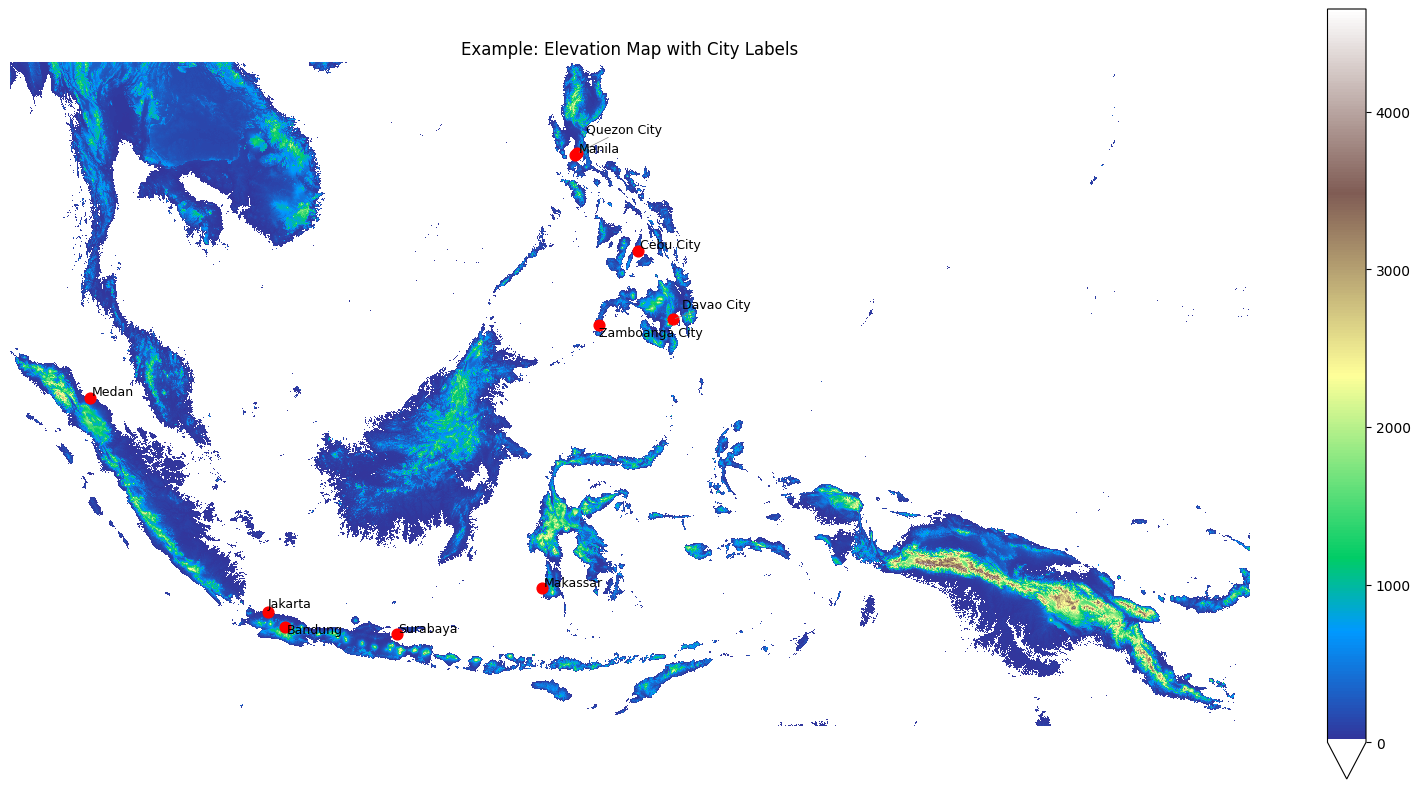

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
## Plot the image
rds.plot(ax=ax, cmap=custom_cmap, vmin=0, vmax=float(rds.max()), add_colorbar=True)
## Plot the points
cities_gdf.plot(ax=ax, color='red', markersize=60)

# Create text objects
## This is a bit tricky; we have to get the positions of each text label in the appropriate co-ordinates. 
## This is how ChatGPT recommends to do it, there may be a more elegant way.
texts = []
for x, y, label in zip(cities_gdf.geometry.x, cities_gdf.geometry.y, cities_gdf["City"]):
    texts.append(ax.text(x, y, label, fontsize=9, color='black'))

## We can now make sure the text doesn't overlap anything it shouldn't. 
## This edits the 'ax' object, which has a location for all of them when we called 'cities_gdf'
# Adjust to reduce overlaps
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Complete the plotting
plt.title("Example: Elevation Map with City Labels")
plt.axis('off')
plt.show()

## Working with Language data

We'll now read in our langugage information, and repeat the transformation above for the City data for them.

In [8]:
collectionsheet=pd.read_excel("OCSEAN_initial_englishsheet.xlsx")
collectionsheet.head()

Unnamed: 0 Language_BasedOnMasterSheet ISO code (from Original_FileName)  \
0           0               Abui Bunggeta                               ABZ   
1           1             Abui Kilakawada                               ABZ   
2           2              Abui Mobyetang                               ABZ   
3           3                 Abui Pelman                               ABZ   
4          10               Agusan Manobo                               MSM   

           COUNTRY  LocalWordsPresent QC_done  \
0        Indonesia                604     Yes   
1        Indonesia                604     Yes   
2        Indonesia                602     Yes   
3        Indonesia                602     Yes   
4  the Phillipines               1225     Yes   

  AddedToTheUnitedLanguagesMasterFile  \
0                                 Yes   
1                                 Yes   
2                                 Yes   
3                                 Yes   
4                                 Yes   

                                             Comment  \
0  Some English and or Indonesian words in this l...   
1  English and English Elicitation notes complete...   
2  English Elicitation = English actually. Some E...   
3  English Elicitation = English actually. Some E...   
4  Tagalog and English present and both match the...   

                              Separator Mismatches_Eng Mismatches_IndoOrTaga  \
0  , and ; and ~ (?). Only used , and ;             41                    87   
1  , and ; and ~ (?). Only used , and ;             41                    87   
2  , and ; and ~ (?). Only used , and ;             41                    87   
3  , and ; and ~ (?). Only used , and ;             41                    87   
4                                     ,          FALSE                 FALSE   

                              Original_FileName  \
0    OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST.xlsx   
1  OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST.xlsx   
2   OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST.xlsx   
3      OCSEAN-ABZ_20240610-PELMAN_WORDLIST.xlsx   
4     OCSEAN-MSM_20240517-WORDLIST_1to1228.xlsx   

                                         QC_FileName  \
0  OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST_PostQC.xlsx   
1  OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST_PostQC...   
2  OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST_PostQC....   
3    OCSEAN-ABZ_20240610-PELMAN_WORDLIST_PostQC.xlsx   
4   OCSEAN-MSM_20240517-WORDLIST_1to1228_PostQC.xlsx   

       Google Map Coordinate  latitude   longitude  Used  Has_IPA  \
0                        NaN       NaN         NaN  True     True   
1                        NaN       NaN         NaN  True    False   
2                        NaN       NaN         NaN  True    False   
3                        NaN       NaN         NaN  True    False   
4  9°15'55.8"N 125°33'33.5"E    9.2655  125.559306  True    False   

   Has_English Language_AsInFile  
0         True     Abui_Bunggeta  
1         True   Abui_Kilakawada  
2         True    Abui_Mobyetang  
3         True       Abui_Pelman  
4         True     Agusan_Manobo

Now we will extract the languages we have location info for. We then have to convert the location into the co-ordinate system used in the plot, which is a two-stage process...

In [9]:
languages=collectionsheet[collectionsheet["latitude"].notnull()].copy()
# Convert to GeoDataFrame
languages["geometry"] = languages.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
languages_gdf = gpd.GeoDataFrame(languages, geometry="geometry", crs="EPSG:4326")
languages_gdf = languages_gdf.to_crs(rds.rio.crs)
languages_gdf.head()

Unnamed: 0 Language_BasedOnMasterSheet ISO code (from Original_FileName)  \
4           10               Agusan Manobo                               MSM   
6           12                     Akeanon                               AKL   
9           18                         Ati                               ATK   
10          19                        Ba'a                               LLG   
12          22                    Bali Aga                               BAN   

            COUNTRY  LocalWordsPresent QC_done  \
4   the Phillipines               1225     Yes   
6   the Phillipines               1123     Yes   
9   the Phillipines                526     Yes   
10        Indonesia               1175     Yes   
12        Indonesia                197     Yes   

                AddedToTheUnitedLanguagesMasterFile  \
4                                               Yes   
6   Yes, but there are problems with a lot of words   
9   Yes, but there are problems with a lot of words   
10                                              Yes   
12                                              Yes   

                                              Comment  \
4   Tagalog and English present and both match the...   
6   A lot of mismatching data in both reference la...   
9   It had two columns of interest: `Ati initial l...   
10  Very messy data columns, a lot of irrelevant a...   
12                                                NaN   

                                            Separator Mismatches_Eng  ...  \
4                                                   ,          FALSE  ...   
6                                             , and /            150  ...   
9                                                   ,            150  ...   
10                                                  ,             57  ...   
12  Space in some words? Don't understand the lang...          FALSE  ...   

                             Original_FileName  \
4    OCSEAN-MSM_20240517-WORDLIST_1to1228.xlsx   
6    OCSEAN-AKL_20240408-WORDLIST_1TO1228.xlsx   
9    OCSEAN-ATK_20240406-WORDLIST_1TO1228.xlsx   
10          OCSEAN-LLG_20220703-WORDLIST.xlsx    
12  OCSEAN-BAN_20240321-BALI_AGA_WORDLIST.xlsx   

                                          QC_FileName  \
4    OCSEAN-MSM_20240517-WORDLIST_1to1228_PostQC.xlsx   
6    OCSEAN-AKL_20240408-WORDLIST_1TO1228_PostQC.xlsx   
9    OCSEAN-ATK_20240406-WORDLIST_1TO1228_PostQC.xlsx   
10           OCSEAN-LLG_20220703-WORDLIST_PostQC.xlsx   
12  OCSEAN-BAN_20240321-BALI_AGA_WORDLIST_PostQC.xlsx   

                      Google Map Coordinate    latitude   longitude  Used  \
4                 9°15'55.8"N 125°33'33.5"E    9.265500  125.559306  True   
6    11.677084170029522, 122.32238044457551   11.677084  122.322380  True   
9                        110.1755, 122.9828  110.175500  122.982800  True   
10  -10.728535222688906, 123.06158269898079  -10.728535  123.061583  True   
12                    -8.237046, 115.028282   -8.237046  115.028282  True   

    Has_IPA  Has_English  Language_AsInFile                           geometry  
4     False         True      Agusan_Manobo   POINT (13977197.959 1035955.892)  
6     False         True            Akeanon    POINT (13616865.104 1308980.31)  
9     False         True                Ati          POINT (Infinity Infinity)  
10     True         True               Ba_a  POINT (13699152.722 -1201335.927)  
12    False         True           Bali_Aga   POINT (12804889.779 -920118.746)  

[5 rows x 21 columns]

## Final plot

the final plot has become complicated due to the need to manually set several things:
1. Adding  color bar scaled to plot size
2. Removing points that are outside the region
3. Preventing overlapping text
4. Showing only land

The end result is quite appealing and helpful.

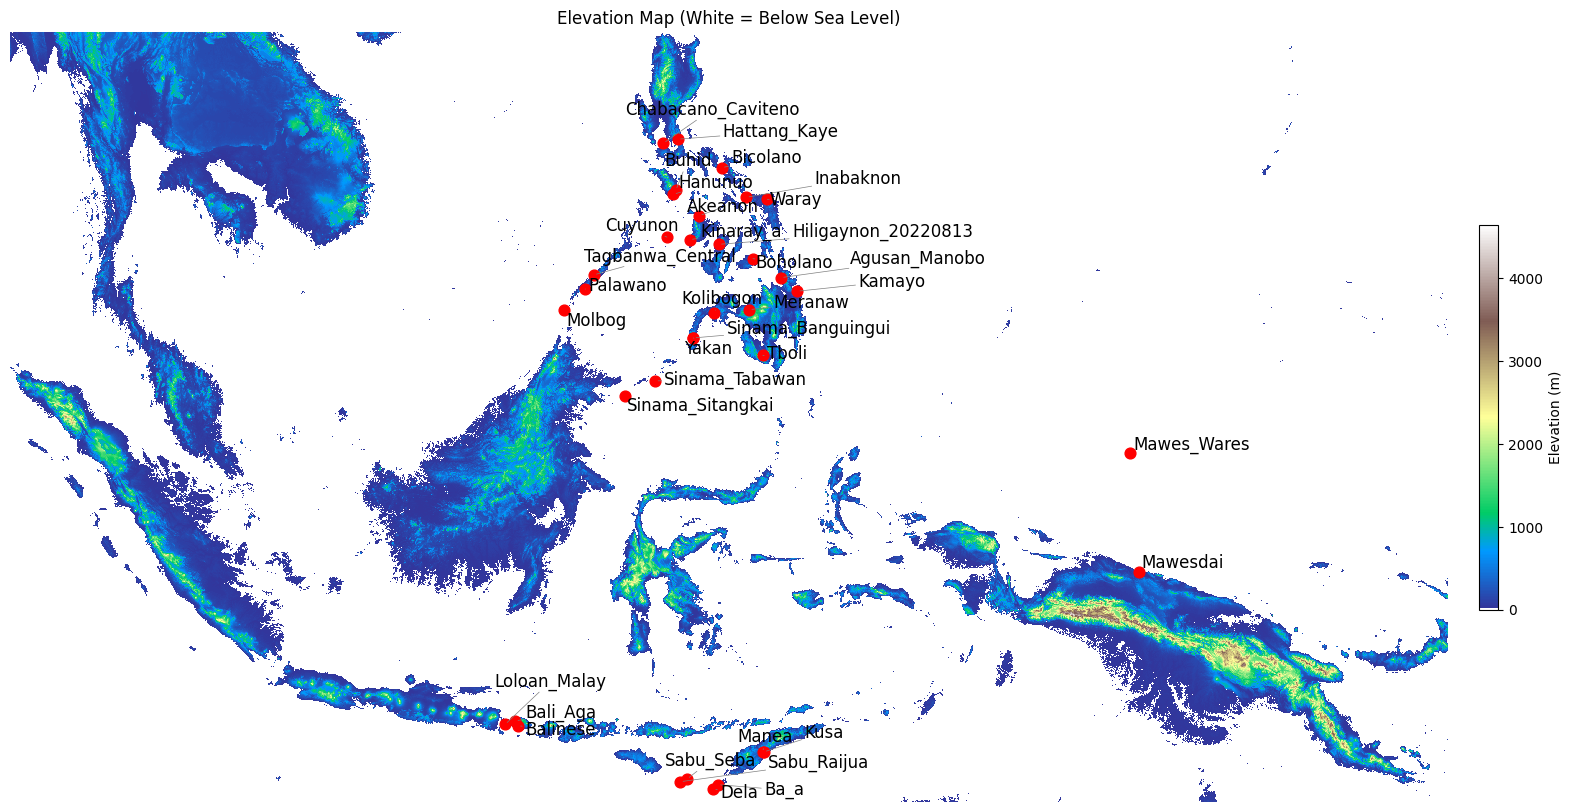

⚠️  4 language(s) were outside the plot area and have been omitted:
['Ati', 'Ivatan_Isabtangen', 'Ivatan_Ichbayatan', 'Pangasinan']


In [10]:
# Plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot and save the QuadMesh object
quadmesh = rds.plot(
    ax=ax,
    cmap=custom_cmap,
    vmin=0,
    vmax=float(rds.max()),
    add_colorbar=False  # Prevent the default large colorbar
)

# Add a custom colorbar using the QuadMesh returned
cbar = fig.colorbar(
    quadmesh,       # this works correctly
    ax=ax,
    fraction=0.03,  # controls width
    shrink=0.5,     # controls length
    pad=0.02        # space between plot and colorbar
)
cbar.set_label("Elevation (m)")

## We have to remove languages that are not in the plot region, or the text adjustment doesn't work
## Find out the range of our data
xlim = ax.get_xlim()
ylim = ax.get_ylim()
in_view = (
    (languages_gdf.geometry.x >= xlim[0]) & (languages_gdf.geometry.x <= xlim[1]) &
    (languages_gdf.geometry.y >= ylim[0]) & (languages_gdf.geometry.y <= ylim[1])
)
# Filter out the data that isn't in the plot region
filtered_df = languages_gdf[in_view]
omitted_df = languages_gdf[~in_view]

# Overlay languages
filtered_df.plot(ax=ax, color='red', markersize=60)

# Create text objects
texts = []
for x, y, label in zip(filtered_df.geometry.x, filtered_df.geometry.y, filtered_df["Language_AsInFile"]):
    texts.append(ax.text(x, y, label, fontsize=12, color='black'))

adjust_text(
    texts, 
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

plt.title("Elevation Map (White = Below Sea Level)")
plt.axis('off')
plt.show()

# Issue a warning if any points were omitted
if not omitted_df.empty:
    print(f"⚠️  {len(omitted_df)} language(s) were outside the plot area and have been omitted:")
    print(omitted_df["Language_AsInFile"].to_list())

IMPORTANT NOTE: Any languages outside the plot area are removed, and should be investigated for why they are. It could be a data error, a plotting region issue, or an automatic conversion of position problem.

# Interactive map

The following code makes an interacive plot, for which I've embedded a still image below. This could be useful for website creation, if we put more work in.

In [13]:

fig = px.scatter_map(
    languages_gdf,
    lat="latitude",
    lon="longitude",
    text="Language_AsInFile",
    zoom=5)
fig.show()


![Image from the above code](https://github.com/danjlawson/ocseanworkshop2025/blob/9de46468346581391b3628862814dc67ee3aa8c7/figs/map_example.png?raw=true)

# Additional reference


## Open Street maps:

[Old walkthrough](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)

[Documentation](https://osmnx.readthedocs.io)

[plotting examples from the oosmnx](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/01-overview-osmnx.ipynb):

## Geopandas

We do use geopandas for plotting points, but not for the raster.

## pygadm

We can also get mapping data (as a map shape instead, using native geopandas) using [pygadm](https://pypi.org/project/pygadm/).
